In [1]:
from matplotlib import pyplot
import numpy
import time

# Set seed of random number generator for reproducibility
numpy.random.seed(123)

In [2]:
# imports from the pyfoomb package
import pyfoomb
print(f'Current package version of {pyfoomb.__name__}: {pyfoomb.__version__}')

from pyfoomb import BioprocessModel
from pyfoomb import ObservationFunction
from pyfoomb import Caretaker
from pyfoomb import Visualization
from pyfoomb import Measurement
from pyfoomb import TimeSeries
from pyfoomb import ParameterMapper
from pyfoomb import Helpers

Could not find GLIMDA.


Current package version of pyfoomb: 2.17.0


# Example bioprocess model

In [3]:
# Defines the model class
class GrowthCoupledProduction(BioprocessModel):       
    
    def specific_growth_rate_mu(self, S):
        kS = self.model_parameters['kS']
        mu_max = self.model_parameters['mu_max']
        kSI = self.model_parameters['kSI']
        mu = mu_max * S / (kS + S + S**2/kSI)
        return mu
    
    
    def specific_production_rate_qP(self, mu):
        YPX = self.model_parameters['YPX']
        qP = YPX * mu
        return qP
    
    
    def specific_substrate_consumption_rate_qS(self, mu, qP):
        YXS = self.model_parameters['YXS']
        YPS = self.model_parameters['YPS']
        qS = 1/YXS * mu + 1/YPS * qP
        return qS

    def get_specific_rates_time_series(self, model_states:list):
        
        # Use the pyFOOMB Helpers method to get a specific TimeSeries object, specified by its `name` and `replicate_id`
        state_S = Helpers.extract_time_series(model_states, name='S', replicate_id=self.replicate_id)
        
        # Get the timepoints and values needed for specific rate calculation
        _t = state_S.timepoints
        _S = state_S.values
        
        # Calculate specific rates vectors
        _mu = self.specific_growth_rate_mu(_S)
        _qP = self.specific_production_rate_qP(_mu)
        _qS = self.specific_substrate_consumption_rate_qS(_mu, _qP)
        
        # Create new corresponding TimeSeries objects
        mu = TimeSeries(name='mu', replicate_id=self.replicate_id, timepoints=_t, values=_mu)
        qP = TimeSeries(name='qP', replicate_id=self.replicate_id, timepoints=_t, values=_qP)
        qS = TimeSeries(name='qS', replicate_id=self.replicate_id, timepoints=_t, values=_qS)
        
        return [mu, qP, qS]
    
    
    def rhs(self, t, y, sw=None):
        
        # Unpacks the state vector. The states are alphabetically ordered.
        P, S, X = y

        # Calculate specific rates
        mu = self.specific_growth_rate_mu(S)
        qP = self.specific_production_rate_qP(mu)
        qS = self.specific_substrate_consumption_rate_qS(mu, qP)

        # Calculate state derivatives
        dXdt = mu * X
        dSdt = -qS * X
        dPdt = qP * X
        
        return [dPdt, dSdt, dXdt]

In [4]:
model_parameters = {
    'kS' : 0.05,
    'kSI' : 75.0,
    'mu_max' : 0.4,
    'YXS' : 0.6,
    'YPS' : 0.4,
    'YPX' : 0.2,
}     

initial_values = {
    'S0' : 20.0,
    'X0' : 0.01,
    'P0' : 0.0,
}

We'll define two replicates, which differ in the initial substrate concentration to show the effect of the substate inhibition.

In [5]:
replicate_ids = ['1st', '2nd']

# Define mapping to make the initial values local parameters for the replicate_id
mappings = [
    ParameterMapper(replicate_id='1st', global_name='S0', local_name='S0_1st', value=25.0),
    ParameterMapper(replicate_id='1st', global_name='X0', local_name='X0_1st', value=0.01),
    ParameterMapper(replicate_id='1st', global_name='P0', local_name='P0_1st', value=0.0),
    ParameterMapper(replicate_id='2nd', global_name='S0', local_name='S0_2nd', value=10.0),
    ParameterMapper(replicate_id='2nd', global_name='X0', local_name='X0_2nd', value=0.01),
    ParameterMapper(replicate_id='2nd', global_name='P0', local_name='P0_2nd', value=0.0),
    
]

As usual, create a `Caretaker` instance and run a forward simulation.

In [6]:
# Instantiates are caretaker with two replicate_ids
caretaker = Caretaker(
    bioprocess_model_class=GrowthCoupledProduction, 
    model_parameters=model_parameters, 
    initial_values=initial_values,
    replicate_ids=replicate_ids,
)

caretaker.apply_mappings(mappings)

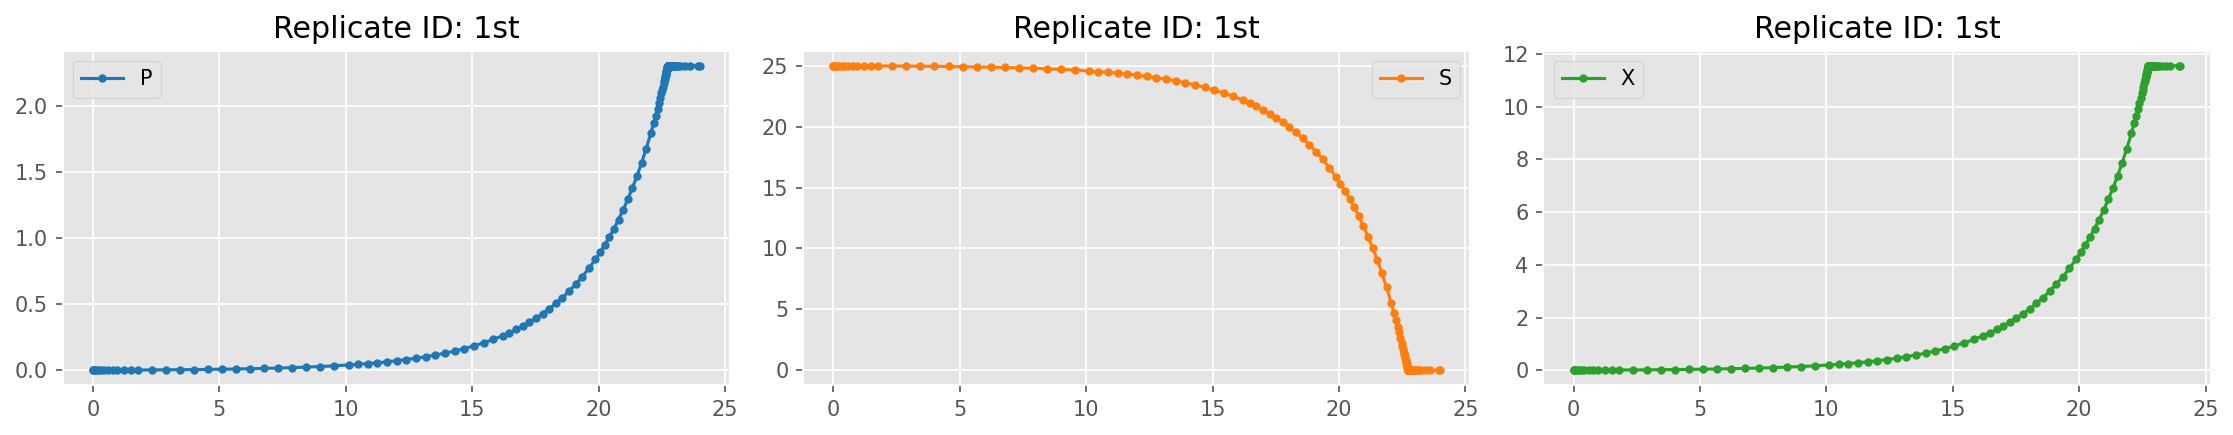

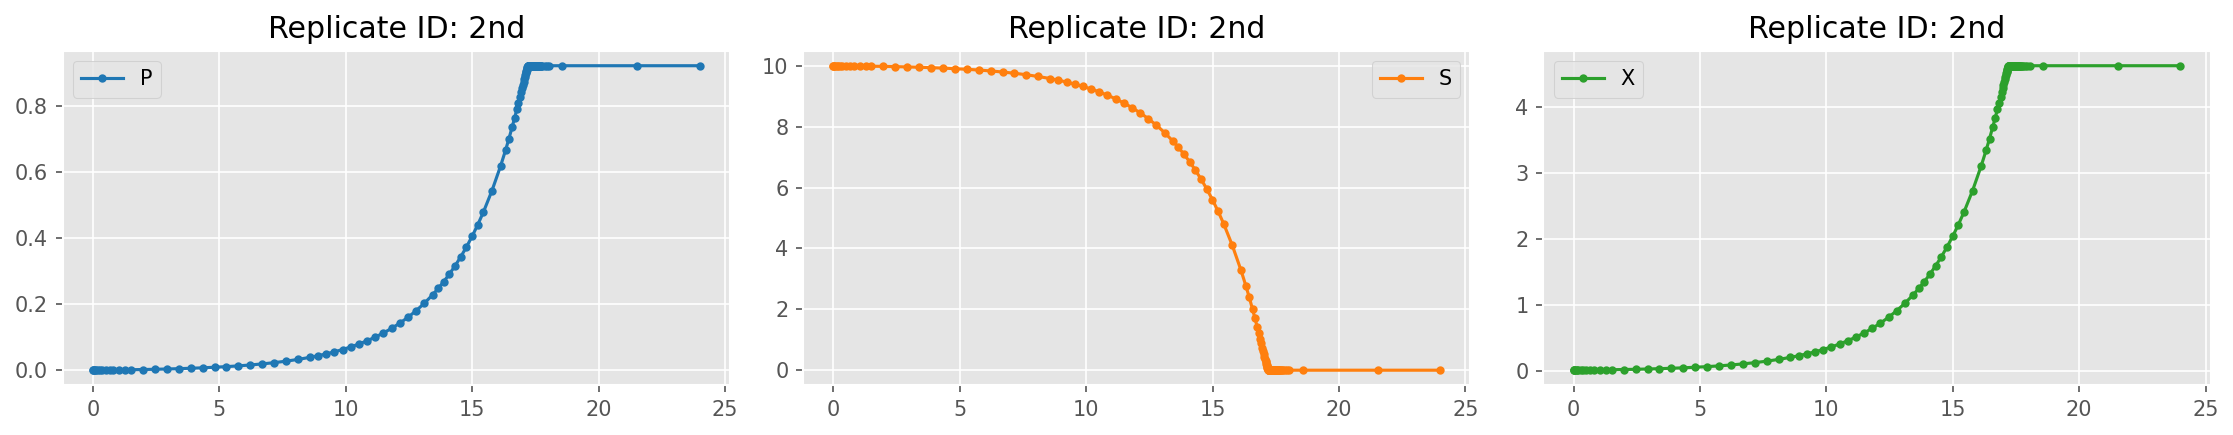

In [7]:
simulation = caretaker.simulate(t=24)
_ = Visualization.show_kinetic_data(simulation)

# Monte-Carlo parameter sampling

Now consider we are interested in how uncertainties for some parameters affect the time courses of state variables and algebraic states, i.e. the specific rates in this example

In [8]:
# Importing a normal distribution
from scipy.stats import norm

n_samples = 500 

YPX_samples = norm.rvs(
    loc=model_parameters['YPX'], 
    scale=model_parameters['YPX']*0.05, # Assuming a relative error of 5 %
    size=n_samples,
)

YPS_samples = norm.rvs(
    loc=model_parameters['YPS'], 
    scale=model_parameters['YPS']*0.1, # Assuming a relative error of 10 %
    size=n_samples,
)

mu_max_samples = norm.rvs(
    loc=model_parameters['mu_max'], 
    scale=model_parameters['mu_max']*0.01, # Assuming a relative error of 1 %
    size=n_samples,
)

mc_parameters = {
    'YPX' : YPX_samples,
    'YPS' : YPS_samples,
    'mu_max' : mu_max_samples,
}

In [9]:
parameter_slices = Helpers.split_parameters_distributions(mc_parameters)

# Exactly the same timepoints are needed to calculate the median values in the new plotting method
t = numpy.linspace(0, 30, 250)

# Request a forward simulation for each parameter slice (Here as generator expression for later execution)
simulations_many = (
    caretaker.simulate(t=t, parameters=_parameters) 
    for _parameters in parameter_slices
)

In [10]:
parameter_slices = Helpers.split_parameters_distributions(mc_parameters)

# Exactly the same timepoints are needed to calculate the median values in the new plotting method
t = numpy.linspace(0, 30, 250)

extended_simulations_many = []
for _parameters in parameter_slices:
    # Set current parameters and run forward simulation
    caretaker.set_parameters(_parameters)
    _simulations = caretaker.simulate(t=t, parameters=_parameters) 
    
    # get specific rates using the forward simulation and the current parameters of the caretaker
    _specific_rates = []
    for rid in caretaker.replicate_ids:
        _specific_rates.extend(
            caretaker.simulators[rid].bioprocess_model.get_specific_rates_time_series(_simulations)
        )
    extended_simulations = [*_simulations, *_specific_rates]
    extended_simulations_many.append(extended_simulations)

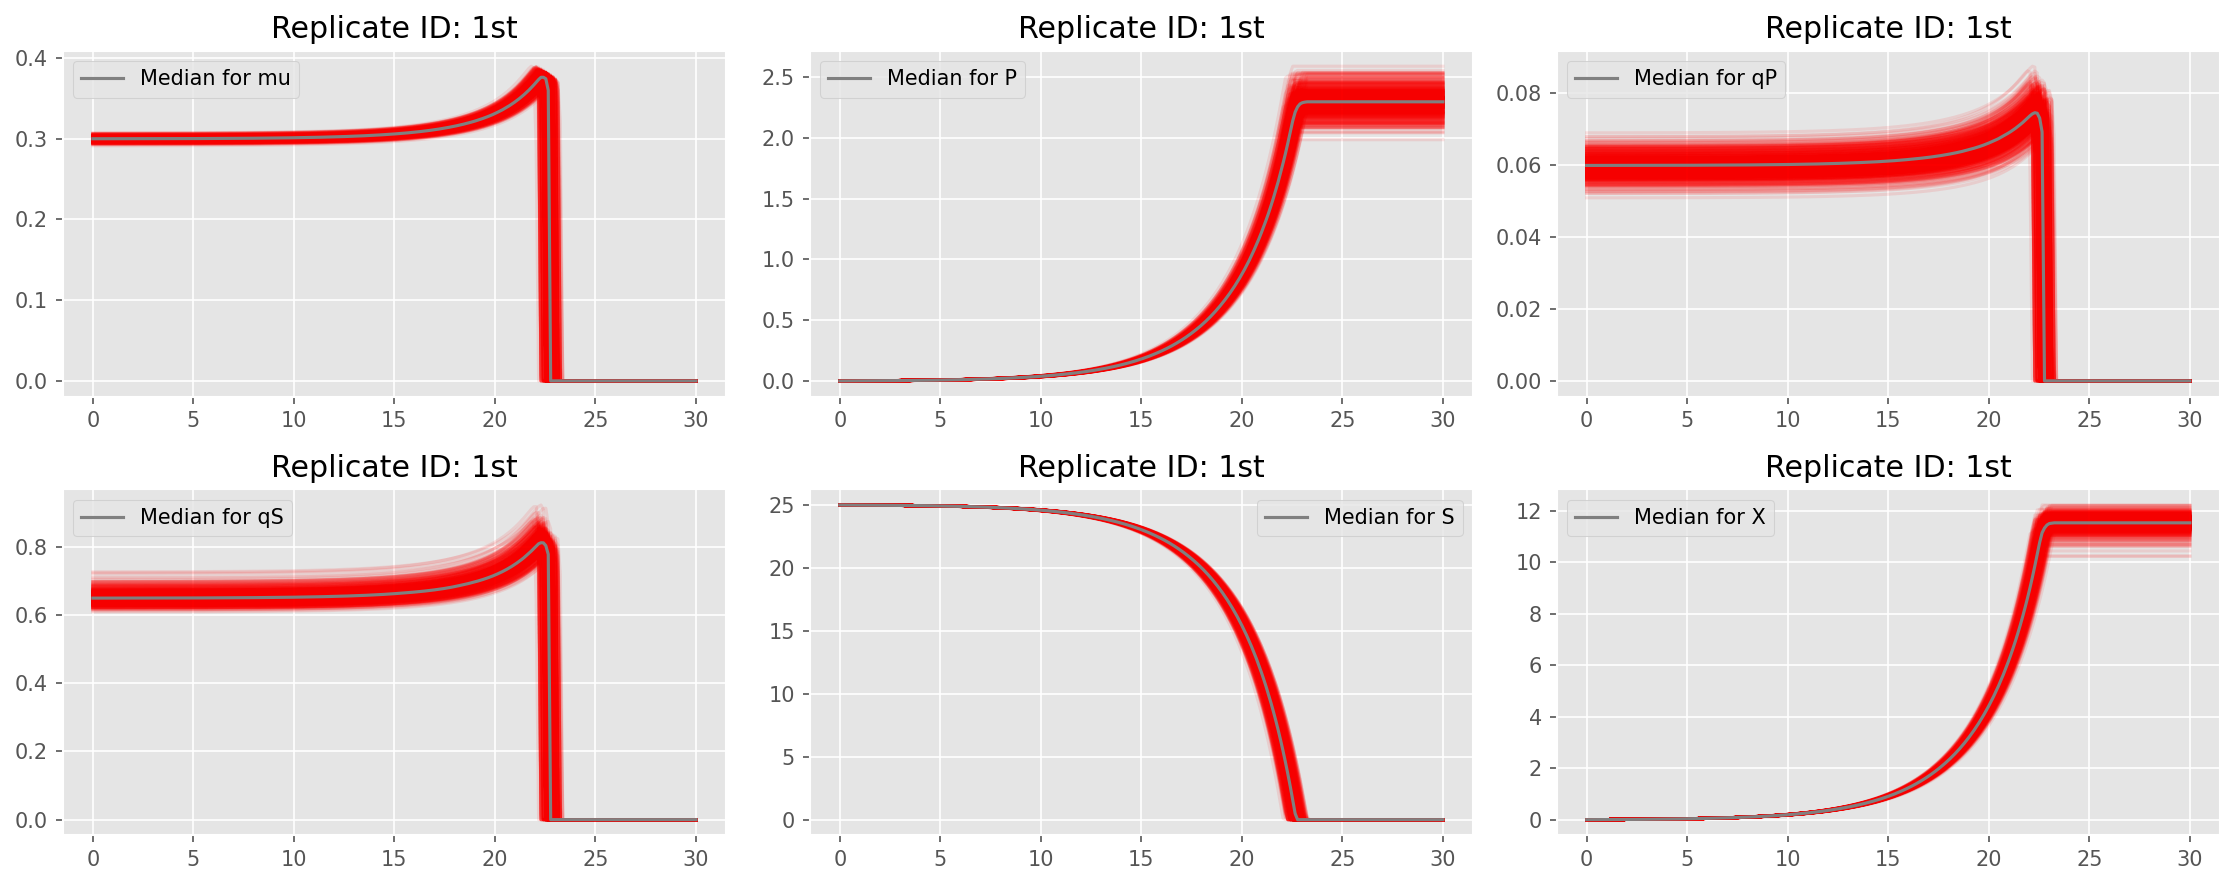

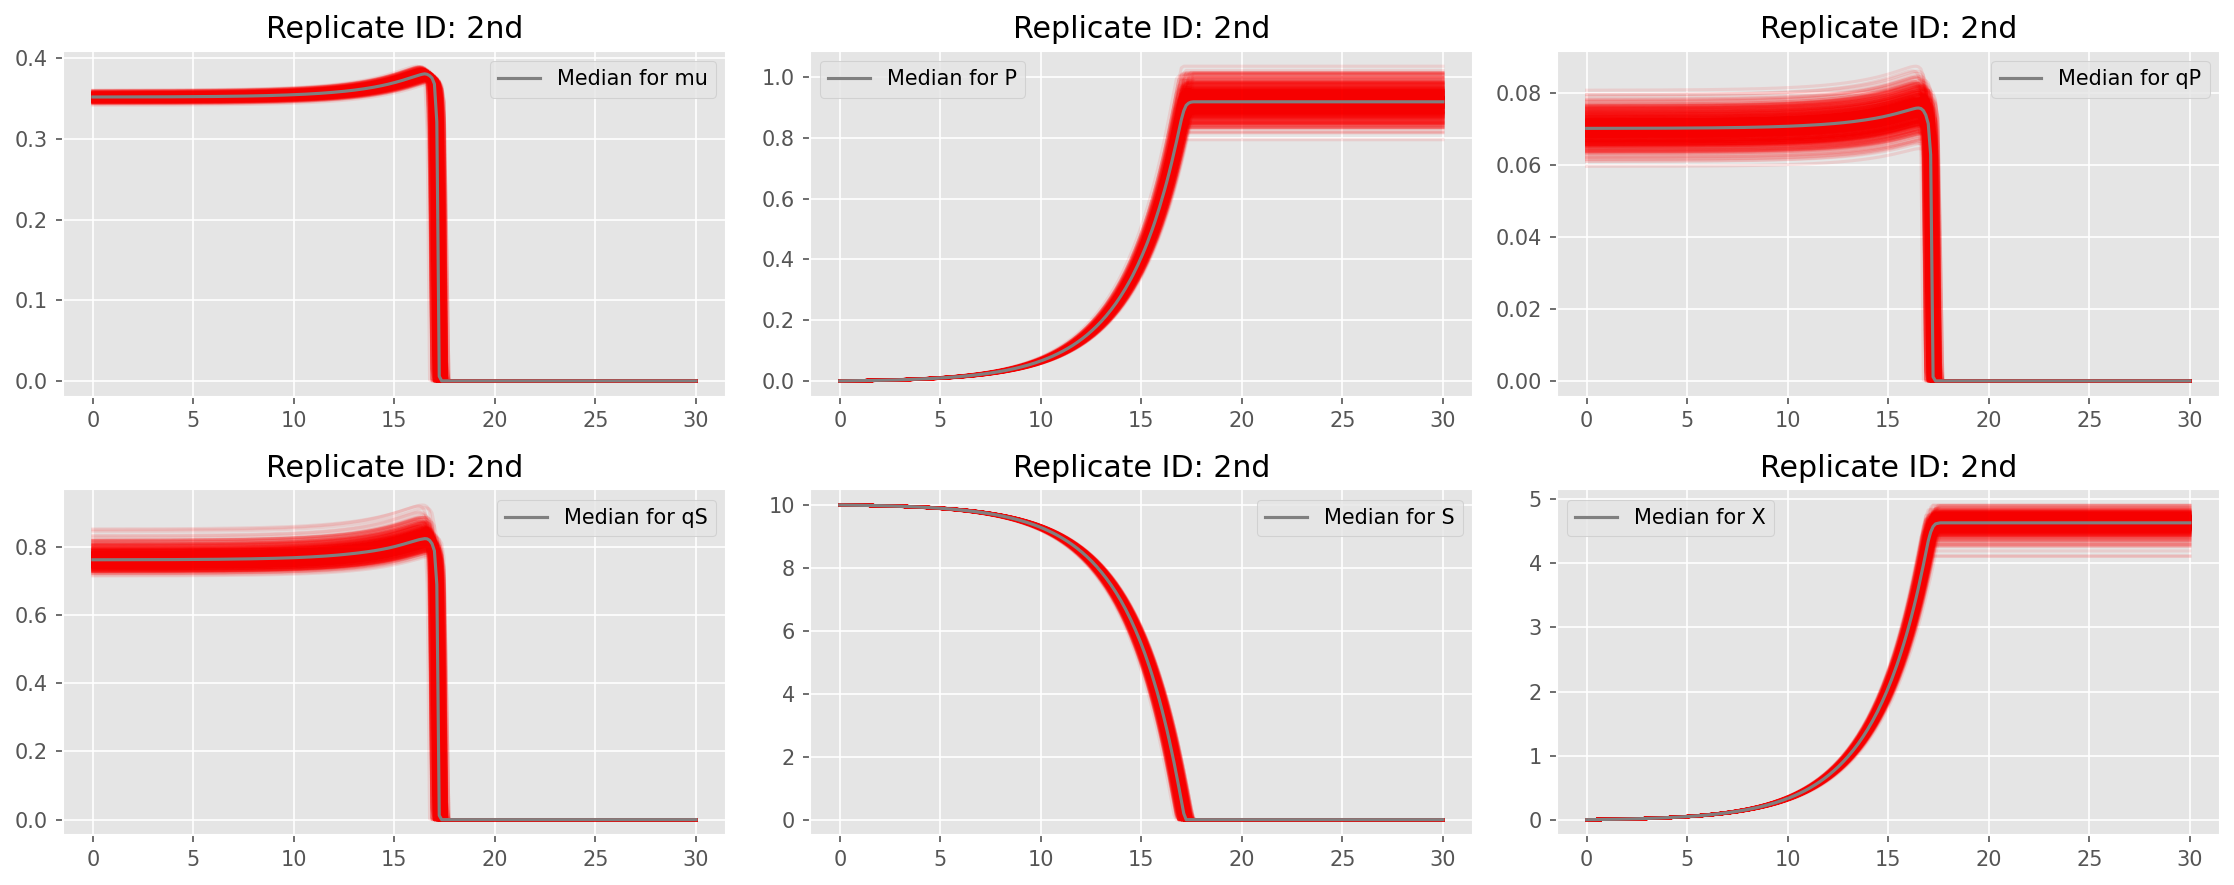

In [11]:
# Now use the new visualization method
_ = Visualization.show_kinetic_data_many(extended_simulations_many)